In [14]:
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt

In [2]:
nf = [200, 400, 600, 800, 1200]
type_ = ['gvip', 'gvidp']
path = './../../../2022l_Distributed-VI/EncodeInfer/figures/'

In [3]:
i, j = 0, 4
filename = 'slam_algo_'+type_[i]+'_nf_'+str(nf[j])+'.pcl'

file = open(filename,'rb')
data_dict = pickle.load(file)
print (data_dict.keys())
X, y = data_dict['train']
Xp, yp = data_dict['verify']
fpoints = data_dict['features']
mean = data_dict['mu']
cov = data_dict['cov']
error = data_dict['error']
T = mean.shape[0]

dict_keys(['train', 'verify', 'features', 'mu', 'cov', 'error'])


In [4]:
len(error), mean.shape

(800, (400001, 1, 1201))

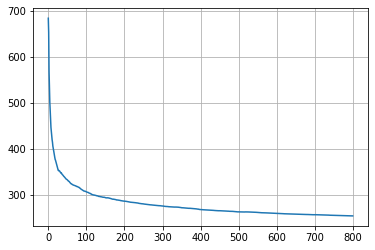

In [5]:
fig, ax = plt.subplots()
ax.plot(error)
ax.grid()

In [6]:
norm_mean = mean[-1,0,1:]
norm_mean = (norm_mean-np.min(norm_mean))/(np.max(norm_mean)-np.min(norm_mean))
norm_cov = np.diag(cov[1:,1:])
norm_cov = (norm_cov-np.min(norm_cov))/(np.max(norm_cov)-np.min(norm_cov))

import matplotlib.cm as cm
from matplotlib.colors import Normalize, rgb2hex
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
def color_map_color(value, cmap_name=cm.get_cmap('bwr'), vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = rgb2hex(rgb)
    return color

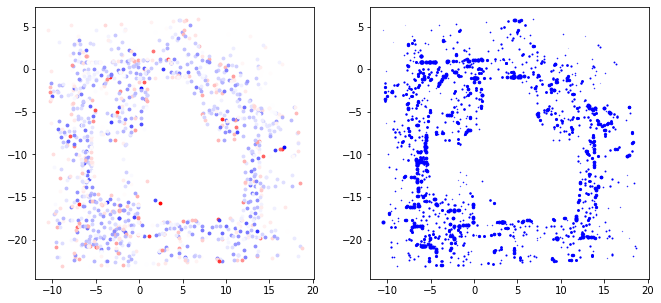

In [7]:
fig, ax = plt.subplots(1,2,figsize=(11,5))
for idx, (x,y) in enumerate(fpoints):
    ax[0].scatter(x, y, c=color_map_color(norm_mean[idx]), s=8)
    ax[1].scatter(x, y, c='b', s=10*norm_cov[idx])


In [7]:
def feature_RBF(x, fpoints, lscale):
    """
    Type: Specify poly or RBF
    args: power of function or feature points
    """
    fpoints = np.vstack((x, fpoints)) # Create bias vector, maybe append lscale here
    nf = fpoints.shape[0]
    # dist = np.linalg.norm(fpoints - np.tile(x, (nf, 1)) , axis = 1)
    dist = np.sum( (fpoints - np.tile(x, (nf, 1)))**2, axis=1)
    return np.exp(-1*dist/(2*lscale**2))
    
def sigmoid(x):
    return 1./(1+np.exp(-x))
    
# @jit(nopython=True)
def forward_model(x, theta, theta_cov, fpoints, lscale):
    Phi_X = feature_RBF(x, fpoints, lscale)
    den = (1+Phi_X@theta_cov.dot(Phi_X.reshape(-1,1)))**(0.5)
    return sigmoid(Phi_X.dot(theta)/den)

In [8]:
len(error)

800

In [9]:
error_arr = np.zeros((len(type_), len(nf), len(error)))
for i,type_i in enumerate(['gvip', 'gvidp']):
    for j,nf_i in enumerate(nf):
        filename = 'slam_algo_'+type_i+'_nf_'+str(nf_i)+'.pcl'        
        file = open(filename,'rb')
        data_dict = pickle.load(file)
        if len(data_dict['error']) == 2:
            error = data_dict['error'][0]
        else:
            error = data_dict['error']
        error_arr[i, j, :] = np.array(error).flatten()

In [10]:
print (error_arr.shape)

(2, 5, 800)


In [11]:
print (plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


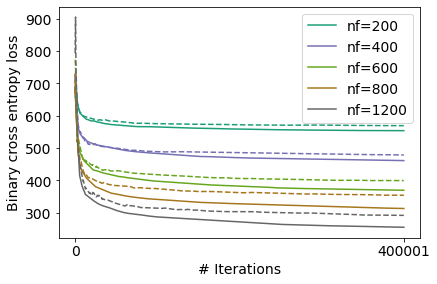

In [28]:
plt.style.use('fast')
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.cm as cm

colors = cm.Dark2(np.linspace(0, 1, len(nf)))
ls_ = ['-', '--']
# Collect error values here
fig, ax = plt.subplots()
fig.tight_layout()
i = 0
for j, nf_i in enumerate(nf):
    ax.plot(np.linspace(0, T, len(error)), error_arr[i,j,:], label='nf='+str(nf_i), color=colors[j], ls=ls_[i])
    
i = 1
for j, nf_i in enumerate(nf):
    ax.plot(np.linspace(0, T, len(error)), error_arr[i,j,:], color=colors[j], ls=ls_[i])
        
ax.legend()
plt.xticks([0, T])
ax.set_xlabel('# Iterations')
ax.set_ylabel('Binary cross entropy loss')
# ax.set_title('Verification loss with feature points and diagonal version')
plt.savefig('error_plots_slam.pdf', bbox_inches='tight')

In [56]:
print (cm.Dark2)

In [57]:
def load_sbkm_parameters():
    parameters = {'intel': \
                      ('./../data/sbkm/data/intel.csv',
                       (0.2, 0.2), # grid resolution for occupied samples and free samples, respectively
                       (-20, 20, -25, 10),  # area to be mapped [x1_min, x1_max, x2_min, x2_max]
                       1, # skip
                       6.71,  # gamma: kernel parameter
                       25, # k_nearest: picking K nearest relevance vectors
                       20 # max_iter: maximum number of iterations
                       ),
                  }
    return parameters['intel']
fn_train, res, cell_max_min, skip, gamma, k_nearest, max_iter = load_sbkm_parameters()
# read data
g = pd.read_csv(fn_train, delimiter=',').values 

In [58]:
# 10% for testing
X_test = np.float_(g[::10, 1:3])
Y_test = np.float_(g[::10, 3][:, np.newaxis]).ravel() 

## Plot predictions

In [59]:
print (g.shape)
lscale = [1.]
for x in fpoints:
    g_idx = np.where(np.linalg.norm(g[:,1:3] - x, axis = 1) == 0.)[0][0] 
    y_label = g[g_idx, 3]
    if y_label == 1:
        lscale.append(1.)
    else:
        lscale.append(0.3)
lscale = np.array(lscale).flatten()
# print (lscale)

(383118, 4)


In [60]:
y_pred = []
for i, x in enumerate(X_test):
    y_pred.append(forward_model(x, mean[-1,0,:], cov, fpoints, lscale)[0])

<AxesSubplot:>

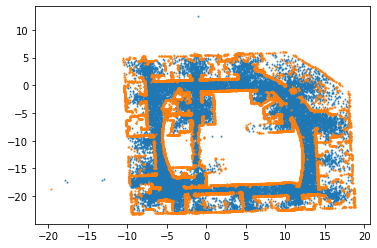

In [61]:
def plot_categorical_data(X, y):
    fig, ax = plt.subplots()
    indices = np.where(np.array(y)==0)
    n_indices = np.where(np.array(y)==1)
    ax.scatter(X[indices, 0], X[indices, 1], marker='^',s=1)
    ax.scatter(X[n_indices, 0], X[n_indices, 1], marker='o',s=1)
    return ax

plot_categorical_data(X_test, Y_test)

Ratio of correct predictions is,  0.8980998120693255


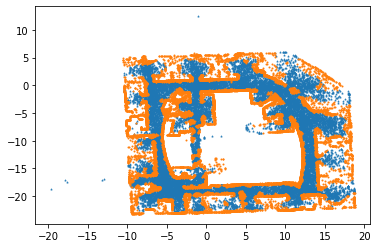

In [62]:
def plot_predict_cat(X, y):
    fig, ax = plt.subplots()
    indices = np.where(np.array(y)<=0.5)
    n_indices = np.where(np.array(y)>0.5)
    ax.scatter(X[indices, 0], X[indices, 1], marker='^', s=1)
    ax.scatter(X[n_indices, 0], X[n_indices, 1], marker='o', s=1)
    return ax

plot_predict_cat(X_test, y_pred)
print ('Ratio of correct predictions is, ', 1.-sum(np.abs(np.round(y_pred) - Y_test))/len(Y_test))

In [19]:
def color_map_color(value, cmap_name=cm.get_cmap('coolwarm'), vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = rgb2hex(rgb)
    return color

In [20]:
X_test.shape

(38312, 2)

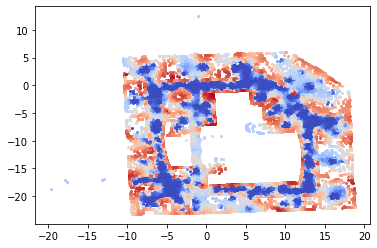

In [21]:
fig, ax = plt.subplots()
norm_mean = np.array(y_pred).flatten()
norm_mean = (norm_mean-np.min(norm_mean))/(np.max(norm_mean)-np.min(norm_mean))

for idx, (x,y) in enumerate(X_test):
    ax.scatter(x, y, c=color_map_color(norm_mean[idx]), s=4)

## Distributed SLAM

In [29]:
nf = 1500
type_ = 'dgvidp'
filename = 'slam_algo_'+type_+'_nf_'+str(nf)+'.pcl'

file = open(filename,'rb')
data_dict = pickle.load(file)
print (data_dict.keys())
X, y = data_dict['train']
Xp, yp = data_dict['verify']
fpoints = data_dict['features']
mean = data_dict['mu']
cov = data_dict['cov']
error = data_dict['error']
b_error = error[0]
lscale = data_dict['lscale']
T = mean.shape[0]
agent_idx = 3
cov0 = cov[agent_idx,:,:]

dict_keys(['A', 'train', 'test', 'verify', 'features', 'mu', 'cov', 'error', 'lscale'])


In [30]:
X.shape, Xp.shape, cov.shape, mean.shape

((4, 72500, 2), (1000, 2), (4, 1501, 1501), (100001, 4, 1501))

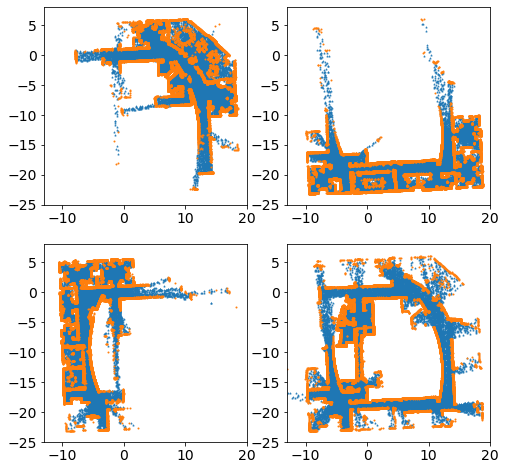

In [31]:
n = X.shape[0]
x_min, x_max = -13, 20
y_min, y_max = -25, 8
        
nrow, ncol = 2,2
fig, ax = plt.subplots(2,2, figsize=(2*n, 2*n))
for idx in range(nrow):
    for idxc in range(ncol):
        didx = 2*idx+ idxc
        
        indices = np.where(np.array(y[didx,:])==0)
        n_indices = np.where(np.array(y[didx,:])==1)
        
        ax[idx, idxc].scatter(X[didx,indices, 0], X[didx,indices, 1], marker='^', s=1)
        ax[idx, idxc].scatter(X[didx,n_indices, 0], X[didx,n_indices, 1], marker='o', s=1)
        ax[idx, idxc].set_xlim([x_min, x_max])
        ax[idx, idxc].set_ylim([y_min, y_max])

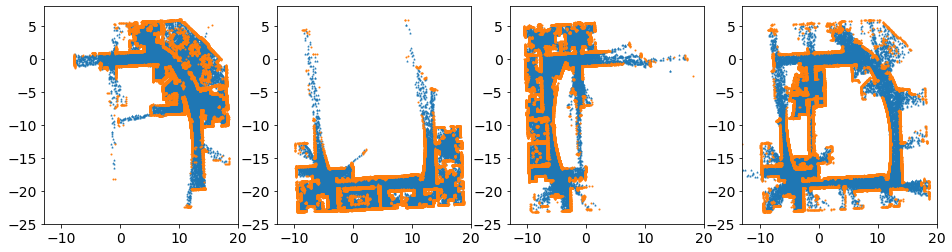

In [32]:
n = X.shape[0]
x_min, x_max = -13, 20
y_min, y_max = -25, 8
        
nrow, ncol = 1,4
fig, ax = plt.subplots(1,4, figsize=(4*n, n))
idx = 0
for idxc in range(ncol):
    didx = idxc

    indices = np.where(np.array(y[didx,:])==0)
    n_indices = np.where(np.array(y[didx,:])==1)

    ax[idxc].scatter(X[didx,indices, 0], X[didx,indices, 1], marker='^', s=1)
    ax[idxc].scatter(X[didx,n_indices, 0], X[didx,n_indices, 1], marker='o', s=1)
    ax[idxc].set_xlim([x_min, x_max])
    ax[idxc].set_ylim([y_min, y_max])

In [31]:
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=2, optimization="random-cd")
X_test_s = sampler.random(n=X_test.shape[0])
X_test_s[:,0] = x_min+(x_max-x_min)*X_test_s[:,0]
X_test_s[:,1] = y_min+(y_max-y_min)*X_test_s[:,1]

<ipython-input-32-cdaaf3d2ee98>:12: RuntimeWarning: divide by zero encountered in true_divide
  ax.scatter(fpoints[:,0], fpoints[:,1], c=colors , s=0.01*(1./norm_cov))


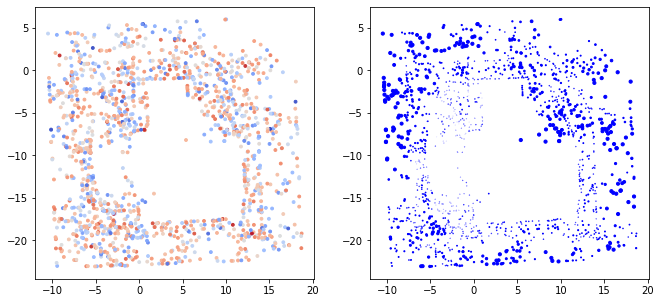

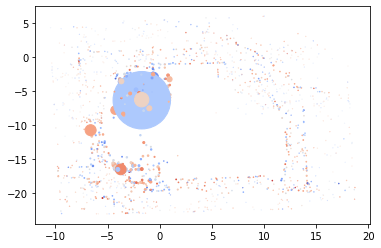

In [32]:
norm_mean = np.array(mean[-1,agent_idx,:]).flatten()
norm_mean = (norm_mean-np.min(norm_mean))/(np.max(norm_mean)-np.min(norm_mean))
norm_cov = np.diag(cov0[1:,1:])
norm_cov = (norm_cov-np.min(norm_cov))/(np.max(norm_cov)-np.min(norm_cov))

fig, ax = plt.subplots(1,2,figsize=(11,5))
colors = [color_map_color(norm_mean[idx],cmap_name=cm.get_cmap('coolwarm')) for idx in range(fpoints.shape[0])]
ax[0].scatter(fpoints[:,0], fpoints[:,1], c=colors , s=8)
ax[1].scatter(fpoints[:,0], fpoints[:,1], c='b', s=10*norm_cov)

fig, ax = plt.subplots()
ax.scatter(fpoints[:,0], fpoints[:,1], c=colors , s=0.01*(1./norm_cov))

In [33]:
# 10% for testing
X_test = np.float_(g[::15, 1:3])
Y_test = np.float_(g[::15, 3][:, np.newaxis]).ravel()

def plot_predict_cat_(ax, X, y):
    indices = np.where(np.array(y)<=0.5)
    n_indices = np.where(np.array(y)>0.5)
    ax.scatter(X[indices, 0], X[indices, 1], marker='^', s=2)
    ax.scatter(X[n_indices, 0], X[n_indices, 1], marker='o', s=2)
    return ax

In [34]:
y_pred = [[] for i in range(n)]

for agent_idx in range(n):
    for i, x in enumerate(X_test):
        y_pred[agent_idx].append(forward_model(x, mean[-1,agent_idx,:], cov[agent_idx,:,:], fpoints, lscale)[0])

Ratio of correct predictions is,  0.8713099992169759


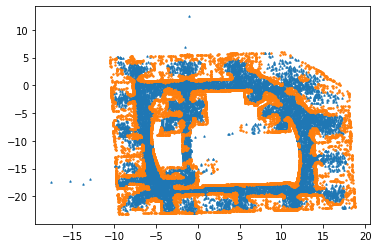

In [35]:
fig, ax = plt.subplots()
plot_predict_cat_(ax, X_test, y_pred[0])
print ('Ratio of correct predictions is, ', 1.-sum(np.abs(np.round(y_pred[0]) - Y_test))/len(Y_test))

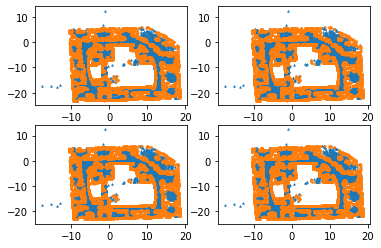

In [64]:
fig, ax = plt.subplots(2,2)
for idx in range(nrow):
    for idxc in range(ncol):
        didx = 2*idx+ idxc
        plot_predict_cat_(ax[idx, idxc], X_test, y_pred[didx])

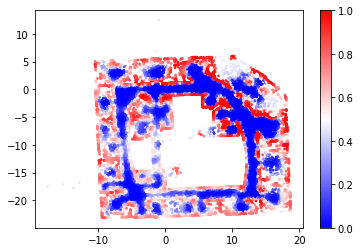

In [65]:
y_norm_mean = np.array(y_pred[0]).flatten()
y_norm_mean = (y_norm_mean-np.min(y_norm_mean))/(np.max(y_norm_mean)-np.min(y_norm_mean))

colors = []
cmap_ = plt.get_cmap('bwr')
for i, x in enumerate(X_test):
    colors.append(color_map_color(y_norm_mean[i],cmap_name=cmap_) )
    
fig, ax = plt.subplots()
img = ax.scatter(X_test[:, 0], X_test[:, 1], c=colors, s=3, alpha=0.9, vmin=0, vmax=1, cmap = cmap_)
img.cmap = plt.cm.bwr
fig.colorbar(img)

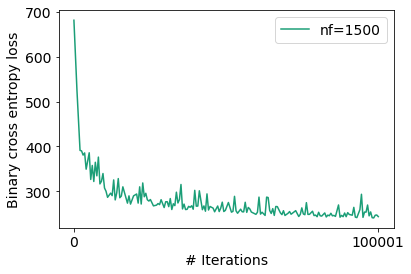

In [36]:
plt.style.use('fast')
import matplotlib.cm as cm

nf = 1
colors = cm.Dark2(np.linspace(0, 1, nf))
ls_ = ['-', '--']
# Collect error values here
fig, ax = plt.subplots()
i = 0
nf_i = 1500
ax.plot(np.linspace(0, T, len(b_error)), b_error, label='nf='+str(nf_i), color=colors[0], ls=ls_[0])

ax.legend()
ax.set_xlabel('# Iterations')
ax.set_ylabel('Binary cross entropy loss')
# ax.set_title('Verification loss in distributed diagonal version')
plt.xticks([0, T])
plt.savefig('ddiag_verify.pdf', bbox_inches='tight')

In [66]:
y_pred = []

for i, x in enumerate(X_test_s):
    y_pred.append(forward_model(x, mean[-1,0,:], cov[0,:,:], fpoints, lscale)[0])

<AxesSubplot:>

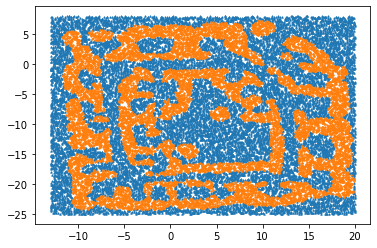

In [67]:
fig, ax = plt.subplots()
plot_predict_cat_(ax, X_test_s, y_pred)

## DiNNO dataset

In [33]:
nf = 1000
type_ = 'dgvidp'
# filename = 'dinno_'+type_+'_nf_'+str(nf)+'.pcl'
filename = 'dinno_'+type_+'_nf_'+str(nf)+'l1'+'.pcl'

file = open(filename,'rb')
data_dict = pickle.load(file)
print (data_dict.keys())
X, y = data_dict['train']
Xp, yp = data_dict['verify']
Xt, yt = data_dict['test']
fpoints = data_dict['features']
mean = data_dict['mu']
cov = data_dict['cov']
error = data_dict['error']
lscale = data_dict['lscale']
A = data_dict['A']
n = np.shape(A)[0]
T = mean.shape[0]
agent_idx = 6
cov0 = cov[agent_idx,:,:]

dict_keys(['A', 'train', 'verify', 'test', 'features', 'mu', 'cov', 'error', 'lscale'])


In [34]:
X[0].shape, Xp.shape, cov.shape, mean.shape

((82000, 2), (23782, 2), (7, 1001, 1001), (100001, 7, 1001))

In [35]:
mean_consensus = np.mean(mean, axis=1)
mean_consensus_repeat = np.repeat(mean_consensus[:, np.newaxis, :], n, axis=1)
consensus_error = np.sum(np.abs(mean-mean_consensus_repeat), axis=2)

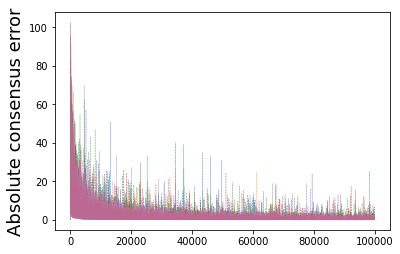

In [36]:
fig, ax = plt.subplots()
ax.plot(consensus_error, '--', linewidth=0.5, alpha=0.5)
# ax.set_xlabel('Iterations', fontsize=18)
ax.set_ylabel('Absolute consensus error', fontsize=18)
# ax.set_title('Consensus error for each agent summed over parameters')

# plt.savefig('dinno_cons_error.pdf', bbox_inches='tight')
plt.savefig(path+'dinno_cons_error.pdf', bbox_inches='tight')

<ipython-input-37-cdaaf3d2ee98>:12: RuntimeWarning: divide by zero encountered in true_divide
  ax.scatter(fpoints[:,0], fpoints[:,1], c=colors , s=0.01*(1./norm_cov))


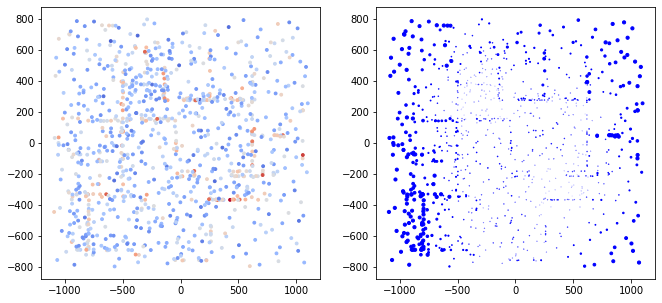

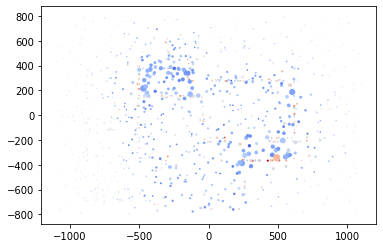

In [37]:
norm_mean = np.array(mean[-1,agent_idx,:]).flatten()
norm_mean = (norm_mean-np.min(norm_mean))/(np.max(norm_mean)-np.min(norm_mean))
norm_cov = np.diag(cov0[1:,1:])
norm_cov = (norm_cov-np.min(norm_cov))/(np.max(norm_cov)-np.min(norm_cov))

fig, ax = plt.subplots(1,2,figsize=(11,5))
colors = [color_map_color(norm_mean[idx],cmap_name=cm.get_cmap('coolwarm')) for idx in range(fpoints.shape[0])]
ax[0].scatter(fpoints[:,0], fpoints[:,1], c=colors , s=8)
ax[1].scatter(fpoints[:,0], fpoints[:,1], c='b', s=10*norm_cov)

fig, ax = plt.subplots()
ax.scatter(fpoints[:,0], fpoints[:,1], c=colors , s=0.01*(1./norm_cov))

In [38]:
def forward_model(x, theta, phi_cov_phi, fpoints, lscale):
    Phi_X = feature_RBF(x, fpoints, lscale)
    den = (1+phi_cov_phi)**(0.5)
    return sigmoid(Phi_X.dot(theta)/den)

y_pred = []

for i, x in enumerate(Xt):
    Phi_X = feature_RBF(x, fpoints, lscale)
    phi_cov_phi = Phi_X@(cov0@Phi_X)
    y_pred.append(forward_model(x, mean[-1,agent_idx,:], phi_cov_phi, fpoints, lscale))
    
def plot_predict_cat(X, y):
    fig, ax = plt.subplots()
    indices = np.where(np.array(y)<=0.5)
    n_indices = np.where(np.array(y)>0.5)
    ax.scatter(X[indices, 0], X[indices, 1], marker='^', s=1)
    ax.scatter(X[n_indices, 0], X[n_indices, 1], marker='o', s=1)
    return ax

<AxesSubplot:>

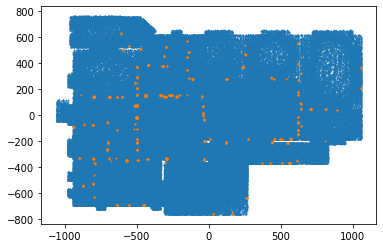

In [40]:
plot_predict_cat(Xt, y_pred)

In [ ]:
y_pred = []
colors = []

for i, x in enumerate(Xt):
    y_pred.append(forward_model(x, mean[-1,0,:], cov, fpoints, lscale))
y_norm_mean = np.array(y_pred).flatten()
y_norm_mean = (y_norm_mean-np.min(y_norm_mean))/(np.max(y_norm_mean)-np.min(y_norm_mean))

In [76]:
for i, x in enumerate(Xt):
    colors.append(color_map_color(y_norm_mean[i],cmap_name=cm.get_cmap('coolwarm')) )

In [77]:
occ_idx = np.where(np.array(y_pred)>0.5)[0]
occ_idx

array([   899,    899,    899, ..., 174491, 174491, 174491], dtype=int64)

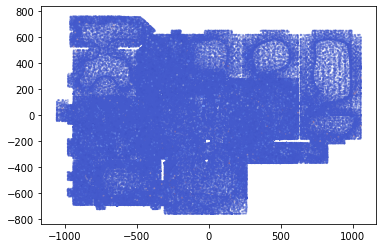

In [78]:
fig, ax = plt.subplots()

ax.scatter(Xf[:, 0], Xf[:, 1], c=colors, s=1, alpha=0.3)
ax.scatter(Xf[occ_idx][:,0], Xf[occ_idx][:,1], c=np.array(colors)[occ_idx], s=1)

7 7


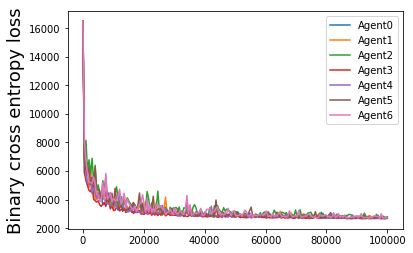

In [39]:
print (len(error[0]), n)
fig, ax = plt.subplots()
t = np.linspace(0, mean.shape[0], len(error[0][0]))
for i in range(n):
    ax.plot(t, error[0][i], label='Agent'+str(i))
    
ax.legend()
# ax.set_xlabel('Iteration', fontsize=18)
ax.set_ylabel('Binary cross entropy loss', fontsize=18)
# ax.set_title('Agent errors on verification set')
plt.savefig(path+'dinno_error.pdf', bbox_inches='tight')

## Banana dataset

In [177]:
type_ = 'gvip'
nf = 50
filename = 'banana'+type_+'_nf_'+str(nf)+'.pcl'

file = open(filename,'rb')
data_dict = pickle.load(file)
print (data_dict.keys())
X, y = data_dict['train']
Xp, yp = data_dict['verify']
Xt, yt = data_dict['test']
fpoints = data_dict['features']
mean = data_dict['mu']
cov = data_dict['cov']
error = data_dict['error']
lscale = data_dict['lscale']
T = mean.shape[0]

dict_keys(['train', 'verify', 'test', 'features', 'mu', 'cov', 'error', 'lscale'])


In [178]:
mean.shape, cov.shape, fpoints.shape, lscale, Xp.shape

((10001, 1, 51),
 (51, 51),
 (50, 2),
 array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
        0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]),
 (663, 2))

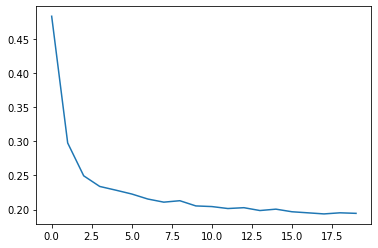

In [179]:
fig, ax = plt.subplots()
ax.plot([val/Xp.shape[0] for val in error[1]])

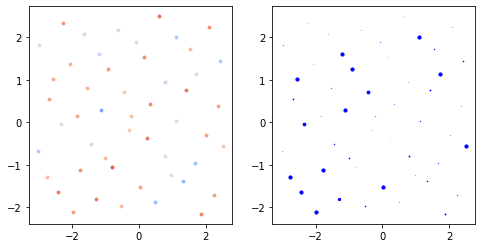

In [180]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
for idx, (x,y) in enumerate(fpoints):
    ax[0].scatter(x, y, c=color_map_color(norm_mean[idx]), s=8)
    ax[1].scatter(x, y, c='b', s=10*norm_cov[idx])

<AxesSubplot:>

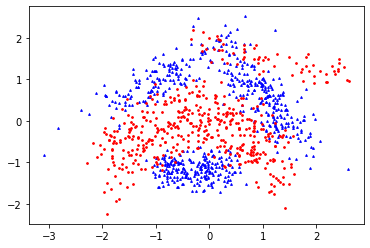

In [181]:
def plot_categorical_data(X, y):
    fig, ax = plt.subplots()
    indices = np.where(np.array(y)==0)
    n_indices = np.where(np.array(y)==1)
    img = ax.scatter(X[indices, 0], X[indices, 1], c='b', marker='^',s=3)
    ax.scatter(X[n_indices, 0], X[n_indices, 1], c='r', marker='o',s=3)
    return ax

plot_categorical_data(Xt, yt)

Ratio of correct predictions is,  0.8839622641509434


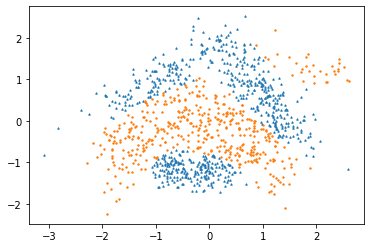

In [182]:
y_pred = []
for i, x in enumerate(Xt):
    y_pred.append(forward_model(x, mean[-1,0,:], cov, fpoints, lscale)[0])
    
def plot_predict_cat(X, y):
    fig, ax = plt.subplots()
    indices = np.where(np.array(y)<=0.5)
    n_indices = np.where(np.array(y)>0.5)
    ax.scatter(X[indices, 0], X[indices, 1], marker='^', s=2)
    ax.scatter(X[n_indices, 0], X[n_indices, 1], marker='o', s=2)
    return ax

plot_predict_cat(Xt, y_pred)
print ('Ratio of correct predictions is, ', 1.-sum(np.abs(np.round(y_pred) - yt))/len(yt))

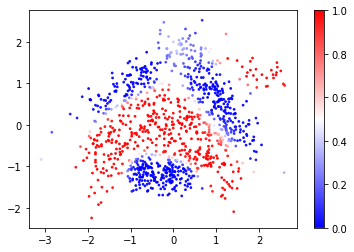

In [183]:
y_norm_mean = np.array(y_pred).flatten()
y_norm_mean = (y_norm_mean-np.min(y_norm_mean))/(np.max(y_norm_mean)-np.min(y_norm_mean))

colors = []
cmap_ = plt.get_cmap('bwr')
for i, x in enumerate(Xt):
    colors.append(color_map_color(y_norm_mean[i],cmap_name=cmap_) )
    
fig, ax = plt.subplots()
img = ax.scatter(Xt[:, 0], Xt[:, 1], c=colors, s=3, alpha=0.9, vmin=0, vmax=1, cmap = cmap_)
img.cmap = plt.cm.bwr
fig.colorbar(img)